In [15]:
import typing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import QuantLib as ql
import yfinance as yf
import constants as cs

[*********************100%%**********************]  2 of 2 completed


,LONN.SW,SIKA.SW
Date,,
2023-08-08,491.200012,267.5


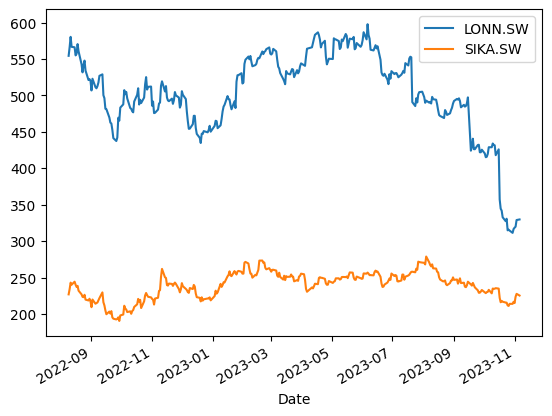

In [4]:
historical_start_date = '2022-08-09'
# Define the ticker list
tickers_list = ['LONN.SW', 'SIKA.SW']

# Fetch the data
data = yf.download(tickers_list, historical_start_date)['Adj Close'] # Auto adjust is false
data.plot()
display(data[data.index == pd.to_datetime('2023-08-08')])

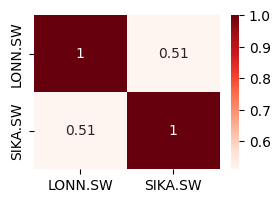

In [5]:
plt.figure(figsize=(3,2))
sns.heatmap(data.corr(), cmap="Reds", annot=True)
plt.show()

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
[Date
2022-08-10    0.021285
2022-08-11    0.024616
2022-08-12   -0.023914
2022-08-15   -0.001053
2022-08-16   -0.019859
                ...   
2023-10-30   -0.009903
2023-10-31    0.016871
2023-11-01    0.005666
2023-11-02    0.004385
2023-11-03    0.028041
Name: LONN.SW, Length: 315, dtype: float64, Date
2022-08-10    0.031246
2022-08-11    0.037225
2022-08-12   -0.011844
2022-08-15    0.017108
2022-08-16   -0.017108
                ...   
2023-10-30    0.000000
2023-10-31    0.012993
2023-11-01   -0.007869
2023-11-02    0.039185
2023-11-03    0.017715
Name: SIKA.SW, Length: 315, dtype: float64]
(2, 315)
[[ 0.02128496  0.03124582]
 [ 0.02461562  0.03722517]
 [-0.02391385 -0.01184415]
 [-0.00105283  0.0171084 ]
 [-0.0198587  -0.0171084 ]
 [ 0.00393202 -0.01240199]
 [ 0.0236218   0.00580673]
 [-0.01757523 -0.02809994]
 [-0.03206895 -0.02193165]
 [-0.02071857 -0.01533441]
 [ 0.01888604 -0.00176755]
 [ 0.01094503  0.

,LONN.SW,SIKA.SW
Date,,
2022-08-11,580.464905,243.206757
2022-08-12,566.748413,240.343170
2022-08-15,566.152039,244.490433
2022-08-16,555.019897,240.343170
2022-08-17,557.206543,237.380844
...,...,...
2023-08-03,490.000000,268.200012
2023-08-04,493.000000,279.000000
2023-08-07,490.200012,271.100006


Covariance matrix is:
 [[0.00039744 0.00023186]
 [0.00023186 0.00042921]]

The shape is (2, 2)

Correlation between the two var is 0.561365644897236
The matrix after Cholesky decomposition is:
 [[0.01993589 0.        ]
 [0.01163006 0.01714509]]

The multiplication of L and L transpose is:
 [[0.00039744 0.00023186]
 [0.00023186 0.00042921]]

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.00039743977849204543 -0.01459945003516385
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.00042921257743639573 0.0020133705663261782
<class 'float'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.00039743977849204543 -0.007538062930632687
<class 'float'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.00042921257743639573 0.006268165877308786
<class 'float'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.00039743977849204543 -0.01909016841112498
<class 'float'> <class 'numpy.float64'> <class 'numpy.float64'>


,LONN.SW,SIKA.SW
0,481.945817,266.053337
1,478.359379,267.744606
2,469.346253,260.201481
3,472.124332,266.544278
4,472.565413,268.239798
...,...,...
58,542.444248,287.059874
59,551.867792,280.815442
60,547.569775,275.299938
61,542.920605,276.751993


63 63


,LONN.SW,SIKA.SW,simulated_LONN.SW,simulated_SIKA.SW
Date,,,,
2023-08-10,498.100006,268.299988,481.945817,266.053337
2023-08-11,494.899994,262.799988,478.359379,267.744606
2023-08-14,494.200012,262.500000,469.346253,260.201481
2023-08-15,487.899994,258.100006,472.124332,266.544278
2023-08-16,479.799988,257.399994,472.565413,268.239798
...,...,...,...,...
2023-10-31,316.799988,216.899994,542.444248,287.059874
2023-11-01,318.600006,215.199997,551.867792,280.815442
2023-11-02,320.000000,223.800003,547.569775,275.299938


/opt/homebrew/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/opt/homebrew/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/opt/homebrew/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/opt/homebrew/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/op

<Axes: xlabel='Date'>

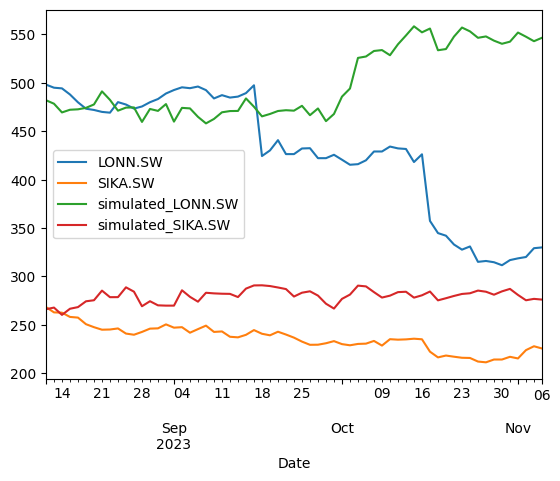

In [18]:
input_date = cs.FIRST_PRODUCT_PRICE_EST_DATE
sim_start_date = input_date + pd.Timedelta(days = 1)
last_avai_price_date = sim_start_date - pd.Timedelta(days = 1)

S_t = [data.loc[last_avai_price_date, ticker] for ticker in tickers_list] # Stock price of the 0th day of simulation
time_steps_per_year = 252
dt = 1/time_steps_per_year
r = 1.750/100 
# TODO: from the simulation date to the final fixing date is roughly 8 months, so I choose a 6-month bond yield that is closest to the time horizon (8 months)
# And then find the closest date to the simulation date (around August 10)
T = 63 # Number of simulation days (#TODO: To be changed later)
num_ticker = len(tickers_list) # Number of stocks

# TODO: Ask if can use historical?
# Use historical data to estimate covariance matrix. (up to last_avai_price date?)

# TODO: Save into a df with dates if needed

hist_data = data[data.index < sim_start_date].tail(time_steps_per_year)
display(hist_data)

log_returns_list = []
for ticker in tickers_list:
    # display(data[ticker], data[ticker].shift(1))
    log_returns = np.log(hist_data[ticker] / hist_data[ticker].shift(1)) # np.log is natural log, (P_i/P_i-1)
    log_returns.dropna(inplace = True) # A series
    log_returns_list.append(log_returns)
    # print(type(log_returns))

# print(log_returns_list)
# print(np.shape(log_returns_list))


# print(f"np.array {np.array(log_returns_list)}")
cov_matrix = np.cov(np.array(log_returns_list))
print(f"Covariance matrix is:\n {cov_matrix}\n")
print(f"The shape is {np.shape(cov_matrix)}\n")

print(f"Correlation between the two var is {cov_matrix[0][1] / (cov_matrix[0][0] * cov_matrix[1][1]) ** 0.5}") # Correct

L = np.linalg.cholesky(cov_matrix)
print(f"The matrix after Cholesky decomposition is:\n {L}\n")

print(f"The multiplication of L and L transpose is:\n {np.dot(L, L.T)}\n") 

sim_data = pd.DataFrame(np.zeros((T, num_ticker)), columns = [tickers_list])

# display(sim_data)
# TODO: N number of simulations
 
# print(sim_data.loc[0, "LONN.SW"])
for t in range(T): # TODO: change to num of days to sim (date range or sth)
    Z = np.random.normal(0, 1, num_ticker) # returns a scalar if size is not specified
    for i in range(num_ticker): # day need to go first, 
        if t == 0: prev_price = S_t[i]
        else: prev_price = sim_data.loc[t - 1, tickers_list[i]].item()
        LZ = np.dot(L, Z)

        print(type(prev_price), type(cov_matrix[i][i]), type(LZ[i]))
        print(r, cov_matrix[i][i], LZ[i])
        sim_data.loc[t, tickers_list[i]] = prev_price * np.exp(r * dt - 0.5 * cov_matrix[i][i] * dt + LZ[i]) # The cov matrix and L need to be computed on the fly

display(sim_data)

sim_data.columns = ["simulated_" + ticker for ticker in tickers_list]

# A dataframe with both validation data and simulated data

val_df = data[data.index >= sim_start_date]
print(len(val_df), len(sim_data))
# Ensure sim_data has the same index as val_df
sim_data.index = val_df.index

# Concatenate val_df and sim_data along columns
val_df_with_sim = pd.concat([val_df, sim_data], axis=1)
display(val_df_with_sim)

# for t in time step from simulation start until end date
# TODO: get market calendar date times: minus weekdays, holidays

val_df_with_sim.plot()
